## Deutsch - Jozsa Algorithm

Here, our goal is to find out whether a boolean function is balanced or constant. In case of balances, the ouput values are 0 for half the inputs and 1 for the other half. In case of constant, all the outputs have same value on the inputs.

If we try to solve this classically, we need to query at least half of the inputs. On the contrary, Deutsch - Jozsa algorithm can do so in one quantum query.

## The Algorithm

The algorithm follows these simple steps:

1. **Prepare two quantum registers** initialized to zero. The first register is an $n$-qubit register for querying the oracle, and the second is a one-qubit register for storing the oracle’s answer:
   
   $$
   |0\ldots 0\rangle |0\rangle
   $$

2. **Create a superposition of all input queries** in the first register by applying the Hadamard gate to each qubit:

   $$
   H^{\otimes^n} |0\ldots 0\rangle |0\rangle = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle
   $$

3. **Flip the second register** and apply the Hadamard gate to it, which stores the oracle's answer in the phase:

   $$
   \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle (|0\rangle - |1\rangle)
   $$

4. **Query the oracle**:

   $$
   \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle (|0\rangle - |1\rangle) \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}(-1)^{f(i)}|i\rangle (|0\rangle - |1\rangle)
   $$

5. **Apply the Hadamard gate** to the first register again.

6. **Measure the first register**. If it is non-zero, the hidden Boolean function is balanced. If it is zero, the function is constant.

### Explanation:

- **Constant function**: When the hidden Boolean function is constant, the quantum states before and after querying the oracle are identical. Since the Hadamard gate is its own inverse, Step 5 essentially reverses Step 2, returning the first register to the all-zero state.
  
- **Balanced function**: When the hidden Boolean function is balanced, the quantum state after querying the oracle becomes orthogonal to the state before querying. Reverting the operation in Step 5 produces a quantum state orthogonal to the initial all-zero state. Therefore, the first register will not measure as all-zero.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached qiskit_ibm_runtime-0.30.0-py3-none-any.whl (2.9 MB)
  Using cached ibm_platform_services-0.57.1-py3-none-any.whl (343 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
  Using cached requests_ntlm-1.3.0-py3-none-any.whl (6.6 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl (58 kB)
  Using cached ibm_cloud_sdk_core-3.21.0-py3-none-any.whl (64 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
     ---------------------------------------- 1.9/1.9 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.1/3.1 MB 3.4 MB/s eta 0:00:00
  Using cached pyspnego-0.11.1-py3-none-any.whl (130 kB)
     -------------------------------------- 181.3/181.3 kB 2.8 MB/s eta 0:00:00
  Using cached PyJWT-2.9.0-py3-none-any.whl (22 kB)
     -------------------------------------- 565.3/565.3 kB 3.9 MB/s eta 0:00:00
     -------------------------------------- 117.6/117.6 kB 7.2 MB/s eta 0:00:00


First of all, we need to set the length of the first register

In [2]:
n = 10

We need to choose our black box / oracle at random, i.e. with half probability that it is constant, and half probability of it being balanced. This code snippet uses numpy's randint function to randomly generate two integer values (either 0 or 1):

In [18]:
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1, 2**n) #hidden parameter

# let us create registers, we need n qubits for querying the oracle and 1 for storing the answer

# all qubits are initialized to 0.
qr = QuantumRegister(n + 1)
cr = ClassicalRegister(n, name ='res')
circuitName = "DeutschJozsa"
circuit = QuantumCircuit(qr, cr)

# we apply the hadamard gate to create the superposition of all the input queries in the first register. 
for i in range(n):
    circuit.h(qr[i])

# for the second register, we first need to flip the bit and then apply hadamard

circuit.x(qr[n])
circuit.h(qr[n])

# a barrier indicates the beginning of an oracle
circuit.barrier();

# The X gate ensures that the oracle always returns 1 (if oracleValue == 1), and the identity (id) gate ensures that the oracle always returns 0 (if oracleValue == 0)

if oracleType == 0:
    if oracleValue == 1:
        circuit.x(qr[n])
    else:
        circuit.id(qr[n])
else: # balanced

    # The CNOT gates are used to calculate the inner product between the input bitstring and the hidden bitstring a.

    for i in range(n):
        if (a & (1 << i)):
            circuit.cx(qr[i], qr[n])

circuit.barrier() # marks end of oracleType

# apply hadamard gate after quering the oracleType
for i in range(n):
    circuit.h(qr[i])

# now let us measure iter

circuit.barrier()

for i in range(n):
    circuit.measure(qr[i], cr[i])


The oracle returns a balanced function


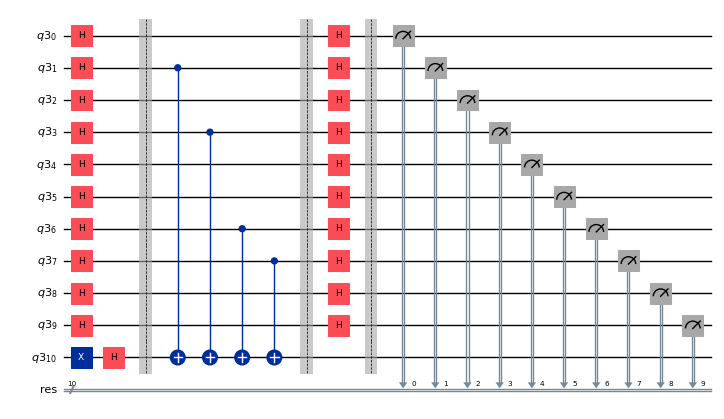

In [19]:
circuit.draw(output='mpl', scale = 0.5)

Now let us run it on a simulator

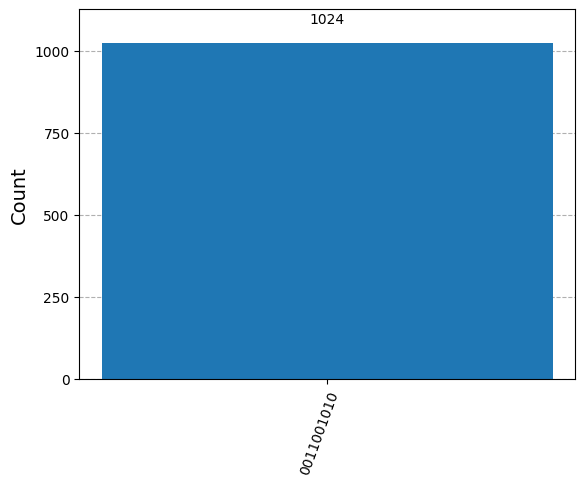

In [20]:
sampler = StatevectorSampler()
job = sampler.run([circuit])
results = job.result()
plot_histogram(results[0].data.res.get_counts())


Repeating the above experiments, we can see that the result of the measurement is an all-zero bitstring if the oracle returns a constant value, or a non-zero bitstring otherwise.